In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite

import random

In [16]:
data = pd.read_csv('movielens-20m-dataset/rating.csv')
movies_df = pd.read_csv("movielens-20m-dataset/movie.csv")
tags_df = pd.read_csv("movielens-20m-dataset/tag.csv")
genome_scores_raw = pd.read_csv("movielens-20m-dataset/genome_scores.csv")
data = data.iloc[:10000]
# Filter genome_scores to only have movieIds present in the data dataframe
genome_scores = genome_scores_raw[genome_scores_raw['movieId'].isin(data['movieId'].unique())]

train_data = data.copy()
test_data = pd.DataFrame()
 
movie_num_user_rated_counts = train_data['movieId'].value_counts()
# Create a list of movie IDs with 50 or more ratings
popular_movies = movie_num_user_rated_counts[movie_num_user_rated_counts >= 10].index.tolist()
# Filter the DataFrame to keep only the rows with movies that meet the threshold
train_data = train_data[train_data['movieId'].isin(popular_movies)]

for user_id in train_data['userId'].unique():
    user_ratings = train_data[train_data['userId'] == user_id]
    
    if len(user_ratings) > 1:
        test_rating = user_ratings.sample()
        test_data = pd.concat([test_data, test_rating])
        train_data.drop(test_rating.index, inplace=True)

In [17]:
def make_graph(train_data, movies_df,tags_df):
    ratings_df = train_data
    # Create a new graph
    G = nx.Graph()

    # 2. Adding nodes and edges
    # Add user nodes
    for user_id in ratings_df['userId'].unique():
        G.add_node('u_'+str(user_id), bipartite=0)  # Add user node with a bipartite attribute of 0

    # Add movie nodes with title and genres as attributes
    for _, row in movies_df.iterrows():
        movie_id = 'm_' + str(row['movieId'])
        G.add_node(movie_id, bipartite=1, title=row['title'], genres=row['genres'].split('|'))

    # Add edges based on ratings with rating and timestamp as attributes
    for _, row in ratings_df.iterrows():
        user_id = 'u_'+str(row['userId'])
        movie_id = 'm_' + str(row['movieId'])
        G.add_edge(user_id, movie_id, rating=row['rating'], timestamp=row['timestamp'])

    # Add tag data as an attribute to the movie nodes
    for _, row in tags_df.iterrows():
        movie_id = 'm_' + str(row['movieId'])
        if 'tags' not in G.nodes[movie_id]:
            G.nodes[movie_id]['tags'] = []
        G.nodes[movie_id]['tags'].append({'tag': row['tag']})

    # Ensure the graph is bipartite
    assert bipartite.is_bipartite(G)
    return G

In [18]:
def predict_rating(G, user, movie):
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    for neighbor in neighbors:
        # Jaccard similarity as an example, but can be changed
        common_movies = list(nx.common_neighbors(G, user, neighbor))
        sim = len(common_movies) / (G.degree(user) + G.degree(neighbor) - len(common_movies))
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)
def recommend_top_5_movies(G, user):
    # All movies in the graph
    all_movies = [node for node in G.nodes() if node.startswith('m_')]
    
    # Movies that the user has already watched
    watched_movies = set(G.neighbors(user))
    
    # Movies to consider for recommendation
    unwatched_movies = set(all_movies) - watched_movies
    
    movie_similarities = {}

    for movie in unwatched_movies:
        # Users who have watched this movie
        users_who_watched = set(G.neighbors(movie))
        
        # Movies watched by those users
        other_movies_watched = set(neighbor for u in users_who_watched for neighbor in G.neighbors(u)) - {movie}
        
        # Common movies watched by the target user and the other users
        common_movies = watched_movies.intersection(other_movies_watched)
        
        # Jaccard similarity as an example
        sim = len(common_movies) / (len(watched_movies) + len(other_movies_watched) - len(common_movies))
        
        movie_similarities[movie] = sim

    # Sort movies by similarity and get top 5
    top_5_movies = sorted(movie_similarities, key=movie_similarities.get, reverse=True)[:5]

    return top_5_movies


In [ ]:
def prepare_data(train_data, genome_scores_data):
    k_relevant_tags = 100  # Replace with the desired number
    
    # Loading the data
    ratings = train_data
    genome_scores = genome_scores_data
    
    
    # Filtering out tags that aren't that important.
    # 1. Compute the average relevance for each tag across all movies.
    avg_relevance = genome_scores.groupby('tagId')['relevance'].mean()

    # 2. Sort the tags by their average relevance and select the X tags with the lowest average relevance.
    top_tags = avg_relevance.nlargest(k_relevant_tags).index

    # 3. Filter out the data in genome_scores based on those selected tags.
    genome_scores = genome_scores[genome_scores['tagId'].isin(top_tags)]
    
    
    # Adjust relevance values in genome_scores such that the median becomes 0
    relevance_median = genome_scores['relevance'].median()
    genome_scores['relevance'] -= relevance_median

    # Scaling the values of relevance
    max_zero_centered_relevance = genome_scores['relevance'].max()
    min_zero_centered_relevance = genome_scores['relevance'].min()
    scaler_positive_values = 0.5 / max_zero_centered_relevance
    scaler_negative_values = -0.5 / min_zero_centered_relevance

    genome_scores['relevance'] = np.where(
        genome_scores['relevance'] > 0,
        genome_scores['relevance'] * scaler_positive_values,
        genome_scores['relevance'] * scaler_negative_values
    ) + 0.5

    # Make relevance and label values be mapped to closest element in bins_values
    bins_values = np.array([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
    genome_scores['relevance'] = genome_scores['relevance'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])

    # Converting ratings to be from 0 to 1 and mapping them to closest element in bins_values
    ratings['rating'] = (ratings['rating'] - 1) / 4
    ratings['rating'] = ratings['rating'].apply(lambda x: bins_values[np.abs(bins_values - x).argmin()])
    
    return ratings, genome_scores, bins_values


def predict_rating_for_movie(user_id, movie_id, ratings, genome_scores, bins_values):
    user_ratings = ratings[ratings['userId'] == user_id]
    movies_rated_by_user = user_ratings['movieId'].tolist()
    genome_scores_movies_rated_by_user = genome_scores[genome_scores['movieId'].isin(movies_rated_by_user)]
    
    
    # Getting the probabilities for all labels
    probability_label = {}
    for label_value in bins_values:
        probability_label[label_value] = compute_movie_output(movie_id, user_id, user_ratings, genome_scores_movies_rated_by_user, genome_scores, label_value)
    
    most_probable_label = max(probability_label, key=probability_label.get)
    return (most_probable_label * 4) + 1


def get_probability(user_ratings, genome_scores_user, tag_id, relevance, label):
    """Function to calculate the probability for a tagId based on user ratings."""
   
    # Filtered genome_scores_user with same relevance for the given tagId
    relevant_movies_rated_by_user = genome_scores_user[(genome_scores_user['tagId'] == tag_id) & (genome_scores_user['relevance'] == relevance)]
       
    if relevant_movies_rated_by_user.empty:
        return 1  # If the user hasn't rated any movies with that relevance and tagId, we'll consider a default probability of 1.
   
    # Count the number of those movies (in relevant_movies_rated_by_user) rated with a value of label
    num_rated_label = user_ratings[user_ratings['movieId'].isin(relevant_movies_rated_by_user['movieId']) & (user_ratings['rating'] == label)].shape[0]
   
    return (num_rated_label / relevant_movies_rated_by_user.shape[0]) + 1


def compute_movie_output(movie_id, user_id, user_ratings, genome_scores_user, genome_scores, label):
    """Function to compute output for a movie based on user's ratings."""
   
    # Get the tag relevance scores for the movie
    movie_relevance_scores = genome_scores[genome_scores['movieId'] == movie_id]
   
    # Calculate the probability for each tagId. It iterates through every row in movie_relevance_scores, passing as parameters the tagId (row['tagId']) and relevance (row['relevance'])
    probabilities = [get_probability(user_ratings, genome_scores_user, row['tagId'], row['relevance'], label) for _, row in movie_relevance_scores.iterrows()]
   
    # Calculate output by multiplying all the probabilities
    output = 1
    for prob in probabilities:
        output *= prob
   
    return output

#Steps:
#Initialize pivot_table -> Initialize Knn -> Use prediction Method
def recommend_top_5_movies_for_user(user_id, ratings, genome_scores, bins_values):
    # Get all movies in the genome_scores
    all_movies = genome_scores['movieId'].unique()
    
    # Movies that the user has already watched
    watched_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
    
    # Movies to consider for recommendation
    unwatched_movies = set(all_movies) - set(watched_movies)
    
    # Predict rating for each unwatched movie
    movie_scores = {}
    for movie in unwatched_movies:
        predicted_rating = predict_rating_for_movie(user_id, movie, ratings, genome_scores, bins_values)
        movie_scores[movie] = predicted_rating

    # Sort movies by predicted rating and get top 5
    top_5_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:5]

    return top_5_movies

In [19]:

def create_pivot_table(data):
    return data.pivot_table(index=["movieId"], columns=["userId"], values="rating").fillna(0)

def create_knn(pivot_table):
    new_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    pivot_matrix = csr_matrix(pivot_table.values) #Required for knn
    new_knn.fit(pivot_matrix)
    return new_knn

#Takes
def predict_user_rating_rafael(userId, movieId, pivot_table, k, knn_model):
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(movieId)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    #print(p_indices)
    p_indices = p_indices[0][1:]
    
    
    #Get users ratings for those movies
    ratings = []
    
    for index in p_indices:
        #print(pivot_table.iloc[index, userId])
        userId_index = pivot_table.columns.get_loc(userId)
        ratings.append(pivot_table.iloc[index, userId_index])
        
        
    #Average their ratings to find their predicted rating for the target movie
    average = sum(ratings)/len(ratings)
    return average


def get_recommendations_knn(userId, k, data):
    pivot_table = create_pivot_table(data)
    knn_model = create_knn(pivot_table)
    
    
    #We will find the user's highest rated movie, so that we can recommend them a similar movie that they are likely to like, or we make a random choice
    #from their top rated movies
    #max_movie_id, max_movie_index, max_rating = get_highest_rated_movie(userId, pivot_table)#Basic method finds a the highest rated movie for a given user (idk what happens if there are more than one say 5 star review)
    
    max_movie_id, max_movie_index = make_random_choice_from_highest_rated_movies(userId, pivot_table)#Basic method finds a the highest rated movie for a given user (idk what happens if there are more than one say 5 star review)
    
    #Get movie's nearest neighbors
    movieId_index = pivot_table.index.get_loc(max_movie_id)
    
    #print(movieId_index)
    #print(pivot_table.iloc[movieId_index,:])
    p_distances, p_indices  = knn_model.kneighbors(pivot_table.iloc[movieId_index,:].values.reshape(1,-1), n_neighbors = k+1)
    return p_distances, p_indices
 
    
def get_highest_rated_movie(userId, pivot_table):
    user_ratings = pivot_table.loc[:, userId]  # Get the ratings for the specific user
    max_rating = user_ratings.max()  # Find the maximum rating for the user
    max_index = user_ratings.idxmax()  # Find the movieId corresponding to the maximum rating
    max_movie_id = pivot_table.index[max_index]
    print("Maximum Rating:", max_rating)
    print("MovieId with Maximum Rating:", max_index)
    return max_movie_id, max_index, max_rating

def make_random_choice_from_highest_rated_movies(userId, pivot_table):
    user_ratings_sorted = pivot_table.loc[:, userId].sort_values(ascending = False) # Get the ratings for the specific user
    user_ratings_sorted = user_ratings_sorted[user_ratings_sorted != 0] #Only consider movies they actually rated
    length = user_ratings_sorted.shape[0]
    
    #random index from top 20% of rated movies 
    index = random.randint(0, math.floor(length*0.01))
    
    max_movie_id = user_ratings_sorted.index[index]#Get the chosen movies movieId
    max_index = pivot_table.index.get_loc(max_movie_id)#Get the index of the movieId from the original pivot table (not the sorted list)
    
    choice = user_ratings_sorted.iloc[index]
    
    return max_movie_id, max_index




In [27]:
def random_walk_legacy(G, start_node, alpha=0.85, walk_length=10):
    """Perform a random walk on graph G starting from node start_node."""
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        if random.random() < alpha and neighbors:
            current_node = random.choice(neighbors)
        else:
            current_node = start_node
        path.append(current_node)
    
    return path

def random_walk_heuristic(G, start_node, movieId_list, alpha=0.85, walk_length=10,seed=None):
    """Perform a random walk on graph G starting from node start_node."""
    current_node = start_node
    path = [current_node]
    if seed:
        random.seed(seed)
    for _ in range(walk_length):
        neighbors = list(G.neighbors(current_node))
        
        if neighbors:
            # Get weights (ratings) of the edges to the neighbors based on distance from the given recommender system's movies.
            weights = []
            
            for neighbor in neighbors:
                #cur_weight = G[current_node][neighbor].get('rating', 1)
                #iterate through all of the recommendations given and find the distances to all of them, sum them to get the weight for this neighbor
                cur_weight = 0
                
                #heursitic contribution
                for movie in movieId_list:
                    cur_weight += nx.shortest_path_length(G, neighbor, G['m_' + str(movie)])
                cur_weight = (cur_weight/len(movieId_list))/2 #average the distances such that sum is between 0-1 and divide by 2
                
                #Rating contribution
                cur_weight += (G[current_node][neighbor].get('rating', 1)/5)/2 #Take the rating (number between 1-5), divide by 2, and add to the total weight
                
                
                weights.append(sum)
            
            
            #weights = [G[current_node][neighbor].get('rating', 1) for neighbor in neighbors]
            
            
            if random.random() < alpha:
                current_node = weighted_choice(neighbors, weights)
            else:
                current_node = start_node
        else:
            current_node = start_node
            
        path.append(current_node)
    
    return path


def get_recommendations(userId, data):
    movieId_list = []
    if(feature_richness == 100):#Knn
        distances, indices = get_recommendations_knn(userId, 5, data)
        movieId_list = indices[0][:].tolist()
        
    return movieId_list
def weighted_choice(neighbors, weights, heur='default',seed=None):
    if seed:
        random.seed(seed)
    if heur=='default':
        total_sum = sum(weights)
        normalized_list = [x / total_sum for x in weights]
        return random.choices(neighbors,weights)[0]
    else:
        total_sum = sum(weights)
        normalized_list = [x / total_sum for x in weights]
        return random.choices(neighbors,weights)[0]

def random_walk(G, start_node, alpha=0.85, walk_length=10, seed=None):
    """Perform a random walk on graph G starting from node start_node."""
    if seed:
        random.seed(seed)
    current_node = start_node
    path = [current_node]
    
    for _ in range(walk_length):
        if seed:
            seed=seed+1
        neighbors = list(G.neighbors(current_node))
        
        if neighbors:
            # Get weights (ratings) of the edges to the neighbors
            weights = [G[current_node][neighbor].get('rating', 1) for neighbor in neighbors]
            
            if random.random() < alpha:
                current_node = weighted_choice(neighbors, weights,seed=seed)
            else:
                current_node = start_node
        else:
            current_node = start_node
            
        path.append(current_node)
    
    return path
def personalized_pagerank_recommendations(G, user, movieId_check=None ,alpha=0.85, num_walks=100, walk_length=10, seed=None):
    """Generate recommendations and explanations using Personalized PageRank via random walks."""
    # Perform random walks and keep track of visit counts
    visit_counts = {node: 0 for node in G.nodes()}
    all_paths = []
    user = 'u_'+str(user)
    if movieId_check:
        match movieId_check:
            case 0:
                movieId_list=get_recommendations_knn(user, 50,data)
            case 1: 
                movieId_list=recommend_top_5_movies(G,user)
            case _:
                raise RuntimeError("Movie ID check failed")
    for _ in range(num_walks):
        if seed:
            seed=seed+10*walk_length
        if movieId_check:
            path = random_walk_heuristic(G, user, movieId_list=movieId_list,alpha=alpha, walk_length=walk_length, seed=seed)
        else:
            path = random_walk(G, user, alpha=alpha, walk_length=walk_length, seed=seed)
        all_paths.append(path)
        for node in path:
            visit_counts[node] += 1
    
    # Normalize visit counts to get a probability distribution
    total_visits = sum(visit_counts.values())
    ppr = {node: count/total_visits for node, count in visit_counts.items()}
    
    # Filter for movies and sort by PPR score
    movies = [node for node in ppr.keys() if G.nodes[node]['bipartite'] == 1 and node not in G.neighbors(str(user))]
    sorted_movies = sorted(movies, key=lambda x: ppr[x], reverse=True)
    
    # Generate explanations for the top 10 movies
    explanations = {}
    significant_neighbors = {}
    contributing_paths_all = {}
    for movie in sorted_movies[:10]:
        # Find paths that contributed to the movie's score
        contributing_paths = [path for path in all_paths if movie in path]
        
        # Count the frequency of each neighbor leading to the movie
        neighbor_counts = {}
        for path in contributing_paths:
            for i in range(len(path) - 1):
                if path[i+1] == movie:
                    neighbor = path[1]
                    neighbor_counts[neighbor] = neighbor_counts.get(neighbor, 0) + 1

        # Identify the most significant neighbor
        sorted_neighbors = sorted(neighbor_counts, key=neighbor_counts.get, reverse=True)
        most_significant_neighbor = next((n for n in sorted_neighbors if not n.startswith('u_') and not n == movie and n in G.neighbors(contributing_paths[0][0])), None)
        if most_significant_neighbor:
            significant_neighbors[movie] = most_significant_neighbor
        contributing_paths_all[movie] = contributing_paths
    return sorted_movies, contributing_paths_all, significant_neighbors,visit_counts


In [22]:
user = train_data['userId'].sample().iloc[0]
G = make_graph(train_data,movies_df,tags_df)
movies, paths, neigbors, visitcounts = personalized_pagerank_recommendations(G,user)
ratings, genome_scores, bins_values = prepare_data(train_data, genome_scores)

In [23]:
def id_to_name(movie_id, movies_df):
    movie_row = movies_df[movies_df['movieId'] == movie_id]
    if not movie_row.empty:
        return movie_row['title'].iloc[0]
    else:
        return None

In [24]:
for neig_key, neig_name in neigbors.items():
    print(f"{neig_key[2:]} : {neig_name[2:]}")
    print(f"{id_to_name(int(neig_key[2:]), movies_df)} : {id_to_name(int(neig_name[2:]), movies_df)}")

593 : 1242
Silence of the Lambs, The (1991) : Glory (1989)
608 : 1
Fargo (1996) : Toy Story (1995)
2858 : 1222
American Beauty (1999) : Full Metal Jacket (1987)
16 : 912
Casino (1995) : Casablanca (1942)
223 : 527
Clerks (1994) : Schindler's List (1993)
1079 : 2797
Fish Called Wanda, A (1988) : Big (1988)
1089 : 1198
Reservoir Dogs (1992) : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
1097 : 2028
E.T. the Extra-Terrestrial (1982) : Saving Private Ryan (1998)
21 : 1196
Get Shorty (1995) : Star Wars: Episode V - The Empire Strikes Back (1980)
32 : 1198
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


In [31]:
def compute_CF(G, user, alpha=0.85, num_walks=10000, walk_length=10, seed=None):
    
    movies, paths, most_neighbors, visit_counts = personalized_pagerank_recommendations(G, user, alpha=alpha, num_walks=num_walks, walk_length=walk_length, seed=seed)
    
    # Get the first node of the first path
    first_path = next(iter(paths.values()))[0]
    first_node_of_first_path = first_path[0]
    
    # Get the node corresponding to the first item in most_neighbors
    node_from_most_neighbors = most_neighbors.get(next(iter(most_neighbors)))
    
    # Remove the edge between the first node of the first path and the node from most_neighbors
    if G.has_edge(first_node_of_first_path, node_from_most_neighbors):
        G.remove_edge(first_node_of_first_path, node_from_most_neighbors)
    if G.has_edge(node_from_most_neighbors, first_node_of_first_path):  # In case the graph is directed
        G.remove_edge(node_from_most_neighbors, first_node_of_first_path)
    
    movies_modified, _, _, visit_counts_modified = personalized_pagerank_recommendations(G, user, alpha=alpha, num_walks=num_walks, walk_length=walk_length, seed=seed)
    first_movie = movies[0]

    if first_movie in movies_modified:
        error = abs(visit_counts[first_movie] - visit_counts_modified[first_movie])
    else:
        error = visit_counts[first_movie]

    #print(f"evaluation error ({first_movie}): {error} first_visits: {visit_counts[first_movie]}")

    return error


In [32]:
import numpy as np

errors = {}
walk_lengths = np.linspace(4, 100, 15).astype(int)  # Generate 15 points between 4 and 100

for walk_length in walk_lengths:
    user_errors = []
    for user in test_data['userId']:
        G_test = G.copy()
        user_error = compute_CF(G_test, user, num_walks=1000, walk_length=walk_length, seed=42)
        user_errors.append(user_error)
    
    # Compute the average error for the current walk length
    avg_error = np.mean(user_errors)
    
    # Store the average error in the errors dictionary
    errors[walk_length] = avg_error


/tmp/ipykernel_79969/3675686180.py:82: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
/tmp/ipykernel_79969/3675686180.py:69: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


evaluation error (m_2571): 3 first_visits: 11
evaluation error (m_1617): 12 first_visits: 12
evaluation error (m_2762): 2 first_visits: 11
evaluation error (m_500): 1 first_visits: 13
evaluation error (m_1): 1 first_visits: 12
evaluation error (m_480): 1 first_visits: 12
evaluation error (m_110): 1 first_visits: 14
evaluation error (m_318): 1 first_visits: 12
evaluation error (m_318): 4 first_visits: 14
evaluation error (m_318): 1 first_visits: 14
evaluation error (m_50): 1 first_visits: 7
evaluation error (m_296): 2 first_visits: 11
evaluation error (m_593): 0 first_visits: 11
evaluation error (m_296): 3 first_visits: 12
evaluation error (m_589): 0 first_visits: 12
evaluation error (m_318): 3 first_visits: 15
evaluation error (m_318): 3 first_visits: 14
evaluation error (m_1197): 1 first_visits: 10
evaluation error (m_593): 2 first_visits: 16
evaluation error (m_858): 1 first_visits: 10
evaluation error (m_110): 4 first_visits: 10
evaluation error (m_153): 9 first_visits: 9
evaluation

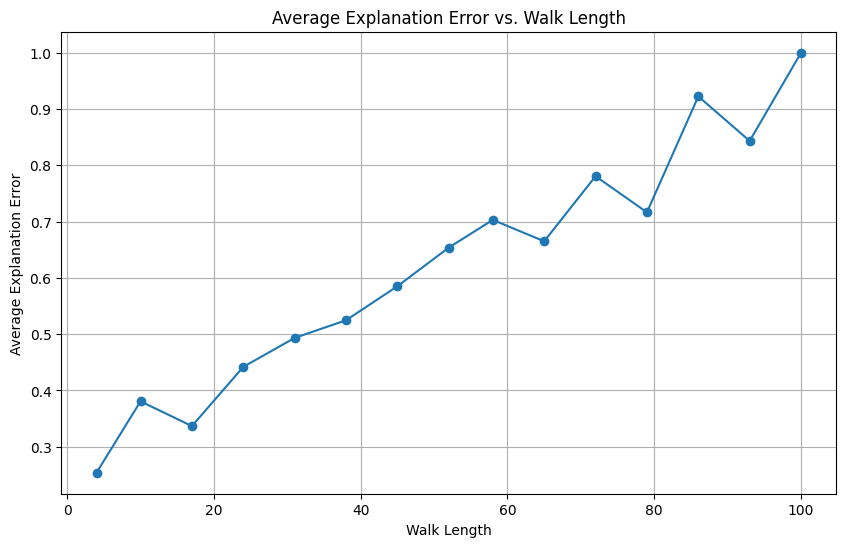

In [35]:
walk_lengths = list(errors.keys())
avg_errors = list(errors.values())/max(list(errors.values()))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(walk_lengths, avg_errors, marker='o', linestyle='-')
plt.title('Average Explanation Error vs. Walk Length')
plt.xlabel('Walk Length')
plt.ylabel('Average Explanation Error')
plt.grid(True)
plt.savefig("hey.png")
plt.show()

In [ ]:
def weighted_rating_score(recommended, user_ratings):
    """Compute a score based on the position in the recommendations and the movie rating."""
    score = 0.0
    for i, movie in enumerate(recommended):
        if movie in user_ratings:
            # Assign higher weight to top-ranked movies
            weight = len(recommended) - i
            score += weight * user_ratings[movie]
    return score

def evaluate_pagerank_recommendations_based_on_ratings(G, train_data, test_data):
    """Evaluate personalized PageRank recommendations using the weighted rating score."""
    scores = []
    
    for user_id in train_data['userId'].unique():
        # Get the ratings for the user from the test set
        user_ratings_df = test_data[test_data['userId'] == user_id]
        user_ratings = dict(zip(user_ratings_df['movieId'], user_ratings_df['rating']))
        
        # Get the top-k recommendations for the user
        recommended, _, _, _ = personalized_pagerank_recommendations(G, user_id)
        
        # Compute the weighted rating score for the user
        scores.append(weighted_rating_score(recommended, user_ratings))
    
    # Compute the average score over all users
    avg_score = sum(scores) / len(scores)
    
    return avg_score

# Evaluate the personalized PageRank recommendations
avg_score = evaluate_pagerank_recommendations_based_on_ratings(G, train_data, test_data)
print(f"Average Weighted Rating Score: {avg_score:.4f}")
